One hidden layer Neural Network algorithm, inspired by course Week3 assignment

1 - loading the dataset

2 - get layers sizes and initialize parameters

3 - forward propagation

4 - gradient descent

5 - backward propagation

6 - update parameters after backpropagation

7 - call the model

8 - predict

In [15]:
# 1 - Loading dataset
# Package imports
import numpy as np
import copy
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model


%matplotlib inline

%load_ext autoreload
%autoreload 2

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

#some utilities
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    

def sigmoid(x):
  
    s = 1/(1+np.exp(-x))
    return s

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
#2 - get the size of the layers and initialize parameters
def layer_sizes(X, Y):
    
    n_x = X.shape[0] #number of input nodes
    n_h = 4      #is the number of nodes in the hidden layer, hardcoded in 4
    n_y = Y.shape[0] #number of output nodes
    
    return (n_x, n_h, n_y)


def initialize_parameters(n_x, n_h, n_y):
    
    #lets initialize weights with random numbers
    #and bias with zero's only
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

We implement `forward_propagation()` using the following equations:

$$Z^{[1]} =  W^{[1]} X + b^{[1]}\tag{1}$$ 
$$A^{[1]} = \tanh(Z^{[1]})\tag{2}$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}\tag{3}$$
$$\hat{Y} = A^{[2]} = \sigma(Z^{[2]})\tag{4}$$

In [17]:
#3 - using forward propagation to determinate parameters


def forward_propagation(X, parameters):
    
    W1 = parameters["W1"]
    b2 = parameters["b2"]
    W2 = parameters["W2"]
    b1 = parameters["b1"]
  
    Z1 = np.dot(W1,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)
    
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

now we can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

In [18]:
#4 - compute cost function

def compute_cost(A2, Y):
   
    m = Y.shape[1] # number of examples

   
    logprobs = np.multiply(np.log(A2),Y) + np.multiply(1 - Y,np.log(1-A2)) 
    cost = (-1/m)*np.sum(logprobs)
    
    
   
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    
    return cost

Now we can compute the backwards propagation to minimize the cost function
<img src="images/grad_summary.png" style="width:600px;height:300px;">
<caption><center><font color='purple'><b>Figure 1</b>: Backpropagation.</font></center></caption>

In [19]:
# 5 - backpropagation

def backward_propagation(parameters, cache, X, Y):
    
    m = X.shape[1]
    
  
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

Now we are going to update the parameters
$\theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

In [20]:
# 6 - updating parameters

def update_parameters(parameters, grads, learning_rate):
   
    
    W1 = copy.deepcopy(parameters['W1'])
    b1 = copy.deepcopy(parameters['b1'])
    W2 = copy.deepcopy(parameters['W2'])
    b2 = copy.deepcopy(parameters['b2'])
 
    
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    
   
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [21]:
# 7 - calling the methods

def nn_model(X, Y, n_h,learning_rate, num_iterations = 10000, print_cost=False):
    
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters
   
    parameters = initialize_parameters(n_x,n_h,n_y)

    # Loop (gradient descent)

    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(parameters,cache,X,Y)
        parameters = update_parameters(parameters,grads,learning_rate)
    return parameters

In [22]:
#8 - predicting
def predict(parameters, X):
   
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2>0.5)
 
    
    return predictions

Accuracy: 90%


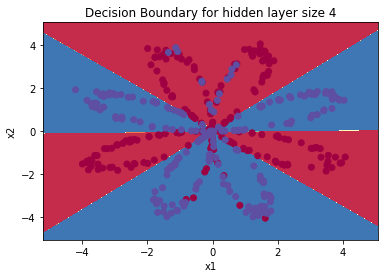

In [25]:
#loading the dataset
X, Y = load_planar_dataset()
# calling the model
parameters = nn_model(X, Y, n_h = 4,learning_rate = 1.2, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

# Printing the accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')